In [1]:
import uproot
import awkward as ak
from uproot_methods import TLorentzVectorArray
import numpy as np
from coffea import processor, util

%matplotlib inline
import matplotlib.pyplot as plt

from boostedhiggs.structure import buildevents

In [8]:
# fin = uproot.open('data/TTToHadronic_TuneCP5_13TeV-powheg-pythia8_10X.root')
# root://cmseos.fnal.gov//store/user/lpchbb/cmantill/pancakes/01/hadd//hwwmc-hadd/RunIIAutumn18MiniAOD-102X_v15-v1_1.root
fin = uproot.open('data/RunIIAutumn18MiniAOD-102X_v15-v1_1.root')
tree = fin['Events']
df = processor.LazyDataFrame(tree, stride=20000, index=0, flatten=True)
events = buildevents(df, fatjet='CustomAK8Puppi')

In [9]:
mus = events.genpart[
    (np.abs(events.genpart.pdgId)==13)
    & ((events.genpart.statusFlags & ((1<<12)|(1<<8))==((1<<12)|(1<<8))))
]
events['hasonegenmu'] = mus.counts == 1

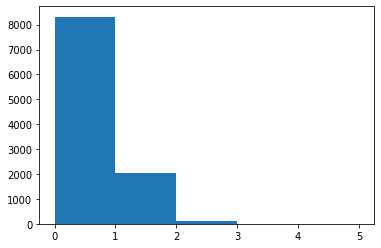

In [43]:
plt.hist(mus.counts, bins=range(6));

In [10]:
good = (
    (events.muons.counts >= 1)
    & (events.fatjets.counts >= 1)
)
events = events[good]

In [12]:
# dont run this
leadingmuon = events.muons.pad(1, clip=True).flatten()
bestidx = leadingmuon.p4.delta_r(events.fatjets.p4) #.fi.argmin()
#leadingjet = 
# leadingjet = events.fatjets.pad(1, clip=True).flatten()
met = events.met

In [13]:
leadingmuon = events.muons[:, 0]
mujet_dR = leadingmuon.p4.delta_r(events.fatjets.p4)
mu_in_cone = mujet_dR.min() < 0.8
bestidx = mujet_dR.argmin()
leadingjet = events.fatjets[bestidx].flatten()
met = events.met

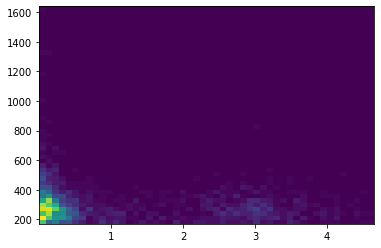

In [14]:
plt.hist2d(
    mujet_dR[events.hasonegenmu].min(),
    leadingjet[events.hasonegenmu].p4.pt,
    bins=50,
);

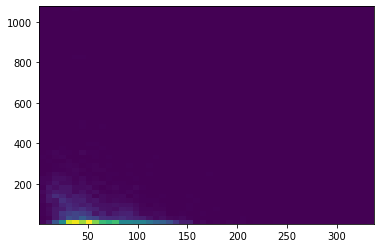

In [27]:
mm = (leadingjet.p4 - leadingmuon.p4).mass2
jmass = (mm>0)*np.sqrt(np.maximum(0, mm)) + (mm<0)*leadingjet.p4.mass
plt.hist2d(jmass, leadingmuon.p4.pt, bins=50);

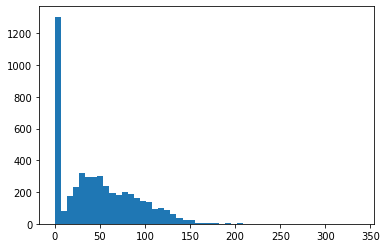

In [30]:
plt.hist(np.sqrt(np.maximum(0, mm)), bins=50);

In [31]:
# joffshell = leadingjet.msoftdrop < 125/2  # halfway point between offshell and onshell W
joffshell = jmass < 62.5
massassumption = 80.*joffshell + (125 - 80.)*~joffshell
x = massassumption**2/(2*leadingmuon.p4.pt*met.rho) + np.cos(leadingmuon.p4.phi - met.phi)
met_eta = (
    (x < 1)*np.arcsinh(x*np.sinh(leadingmuon.p4.eta))
    + (x >= 1)*(
        leadingmuon.p4.eta
        - np.sign(leadingmuon.p4.eta)*np.arccosh(np.maximum(1., x))
    )
)
met_p4 = TLorentzVectorArray.from_ptetaphim(met.rho, met_eta, met.phi, np.zeros(met.size))

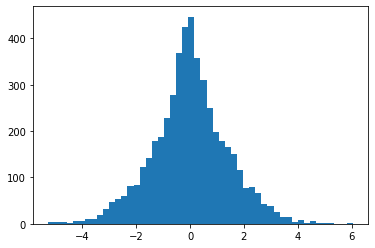

In [33]:
plt.hist(met_eta, 50);

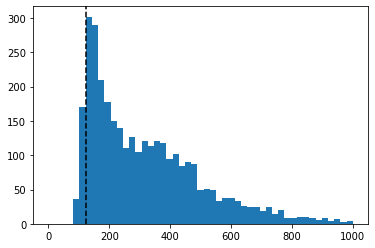

In [39]:
# jetp4sd = TLorentzVectorArray.from_ptetaphim(
#     leadingjet.p4.pt,
#     leadingjet.p4.eta,
#     leadingjet.p4.phi,
#     leadingjet.msoftdrop,
# )
cut = (leadingjet.p4.pt > 200) & (mm > 0)
#plt.hist((met_p4 + leadingmuon.p4 + jetp4sd).mass, np.linspace(0, 1000, 50));
plt.hist((met_p4 + leadingjet.p4).mass[cut], np.linspace(0, 1000, 50));
plt.axvline(125., linestyle='--', color='k')

In [ ]:
# fillna assign in place, modifying content?
# two arrays with different mask can't be added?

In [40]:
bosons = events.genpart[
    (np.abs(events.genpart.pdgId) >= 21)
    & (np.abs(events.genpart.pdgId) <= 37)
    & (events.genpart.statusFlags & ((1<<7)|(1<<13))).astype(bool)  # isHardProcess, isLastCopy
    & (events.genpart.genPartIdxMother >= 0)
]
candidatejet = events.fatjets.pad(1, clip=True).flatten()
dR2 = candidatejet.p4.delta_r2(bosons.p4)
dPt2 = ((candidatejet.p4.pt - bosons.p4.pt)/(candidatejet.p4.pt + bosons.p4.pt))**2
(dR2 + dPt2).argmin()

<IndexedMaskedArray [[9] [0] [26] ... [4] [0] [1]] at 0x000120cd58d0>